# スライディングモード制御による倒立振子制御
 ode_module.ipynbで用意したサンプルをそのまま使用した結果を表示

In [2]:
# --------------------------------------------
# 基本モジュール
import sys, os
from pathlib import Path
from datetime import datetime as date
from ctypes import cdll, c_double

# --------------------------------------------
print('Major version: {}'.format(sys.version_info.major))
print('Minor version: {}'.format(sys.version_info.minor))
print('Micro version: {}'.format(sys.version_info.micro))

# --------------------------------------------
# 算術処理・描画処理
from math import *               # 基本オペレータ
import numpy as np               # 算術処理
import pandas as pd              # データフレーム
import matplotlib.pyplot as plt  # グラフ描画

# --------------------------------------------
# 自作モジュールディレクトリをパスに追加
#current_dir = os.path.join(Path().resolve())
#sys.path.append(str(current_dir) + '\my_lib')
sys.path.append(os.path.join(os.getcwd(), 'my_lib'))

# --------------------------------------------
# .ipynbファイルをimportするためのスクリプトをimportした後、
# ODEシミュレーションモジュールをimport
import ipynb_import_lib
ode = ipynb_import_lib.import_ipynb("my_lib\ode_module.ipynb", no_expr=False)

Major version: 3
Minor version: 8
Micro version: 10


FileNotFoundError: [Errno 2] No such file or directory: 'my_lib\\ode_module.ipynb'

In [2]:
def motion(tim, state, const, ctrl_in, depends):
  #-------------------------  
  x  = state.x
  dx = state.dx
  f1 = ctrl_in[1]
  f2 = ctrl_in[2]
  #-------------------------  
  dx[0] = x[1]          # p' = v
  dx[1] = f1/const.M    # v' = f/M
  dx[2] = x[3]          # p' = v
  dx[3] = f2/const.M    # v' = f/M

In [3]:
def controller(tim, state, const, depends):
  def sgn(x):
    return int(x>0) - int(x<0)
  #-------------------------  
  x  = state.x
  p  = x[0]
  v  = x[1]
  p2  = x[2]
  v2  = x[3]
  #-------------------------  
  F  = const.F
  K  = const.K
  B  = const.B
  H  = const.H
  T  = const.T
  #-------------------------
  pd = 0
  vd = 0
  if tim>0.1:
    pd = 100
  if tim>3:
    pd = 100 * sin(4*pi*(tim-3)-pi/2)
    vd = 100 * 4 * pi * cos(4*pi*(tim-3)-pi/2)
  #-------------------------
  s  = (pd - p) + H * (vd - v)
  u  = ((B+K*T)*s + (K*H-B) * const.e)/(H+T)
  if abs(u) <= F:
    f = u
  else:
    f  = F * sgn(u)
  const.e = (B * const.e + T*f)/(B+K*T)
  #-------------------------
  #f2 = 5 * (pd - p2) + 0.3 * (vd - v2)
  f2 = 5 * (pd - p2) + 0.6 * (vd - v2)
  
  return [pd, f, f2]

### シミュレーション

In [4]:
# --------------------------------------------
# シミュレーションで使用する定数を指定
# 指定した定数は運動方程式及び制御器の引数に渡される
c = ode.const()
c.F = 1000
c.K = 1000000
c.B = 100
c.H = 0.1
c.M = 0.01
c.T = 0.001
c.e = 0

#motion = ode.motion
#controller = ode.controller

#----------------------------------------------------
# 時間ステップ更新処理用のstepperを設定
# stepperクラスでRunge-Kutta-Gill法による4次精度常微分方程式の数値積分を実施
# stepperクラスでは、運動方程式(func)と制御器（ctrl）に関数ポインタを設定
s1 = ode.stepper(func    = motion,     # equation of motion
                 x0      = [0]*4,      # initial state
                 cnst    = c,          # constant
                 ctrl    = controller, # digital controller
                 period  = c.T,        # control period
                 depends = []          # dependent node name
                 )
  
#----------------------------------------------------
# 数値シミュレーション実行用のノードを設定
# ノード登録順が時間ステップの更新順
# ノード名前によりノード間の依存がある場合の参照・結果の辞書登録を実施
exe = ode.executor()
exe.add('test' , s1)
exe.dispOrder()        # ノード実行順・依存関係を表示

#----------------------------------------------------
# 数値シミュレーションを実施（刻み時間dt[sec]、終了時間[smt]）
# シミュレーション結果はpandasのデータフレーム（df_）
df_x, df_u = exe.sim(dt=0.001, smt=6)

modelName = 'test'
dfx = df_x[modelName]  # 状態量の時間履歴
dfu = df_u[modelName]  # 制御入力の時間履歴

# --------------------------------------------
tdatetime = date.now()
tstr = tdatetime.strftime('%Y-%m-%d_%H:%M:%S')
print(tstr)

no, Name, depends
-----------------
0, test



2021-01-18_23:37:16


### 結果の描画

* 倒立振子角度(x0)と角速度(x1)の時間履歴
* 角度と角速度の相平面遷移図

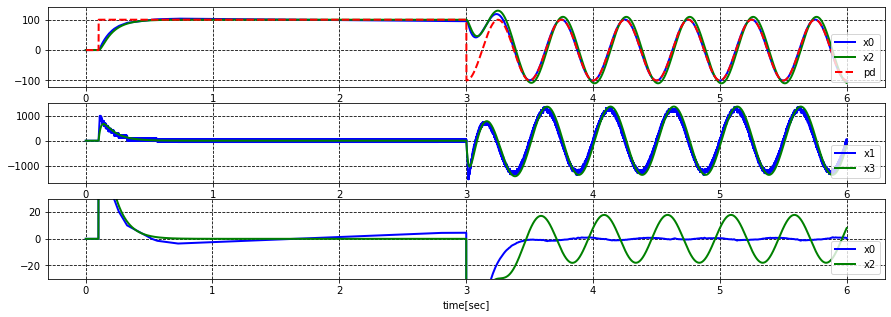

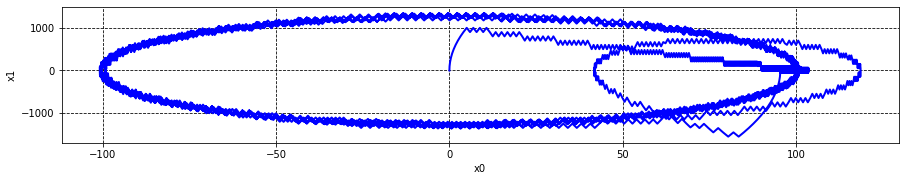

In [5]:
# plot
fig = plt.figure(figsize=(15,5))
N = 3

# --------------------------------------------
# 状態量の時間履歴を描画
ax = fig.add_subplot(N,1,1)
ax.plot(dfx.index, dfx.iloc[:,0], label="x"+str(0), color='b', linewidth=2, linestyle='-')
ax.plot(dfx.index, dfx.iloc[:,2], label="x"+str(2), color='g', linewidth=2, linestyle='-')
ax.plot(dfu.index, dfu.iloc[:,0], label="pd", color='r', linewidth=2, linestyle='--')
ax.set_xlabel('time[sec]')
plt.legend(loc='lower right')
plt.grid(which='major',color='black',linestyle='--')
#----
ax = fig.add_subplot(N,1,2)
ax.plot(dfx.index, dfx.iloc[:,1], label="x"+str(1), color='b', linewidth=2, linestyle='-')
ax.plot(dfx.index, dfx.iloc[:,3], label="x"+str(3), color='g', linewidth=2, linestyle='-')
ax.set_xlabel('time[sec]')
plt.legend(loc='lower right')
plt.grid(which='major',color='black',linestyle='--')
#----
ax = fig.add_subplot(N,1,3)
ax.plot(dfx.index, dfu.iloc[:,0]-dfx.iloc[:,0], label="x"+str(0), color='b', linewidth=2, linestyle='-')
ax.plot(dfx.index, dfu.iloc[:,0]-dfx.iloc[:,2], label="x"+str(2), color='g', linewidth=2, linestyle='-')
ax.set_xlabel('time[sec]')
plt.legend(loc='lower right')
plt.ylim(-30,30)
plt.grid(which='major',color='black',linestyle='--')
#----
plt.show()

# --------------------------------------------
# 状態量の相平面
fig = plt.figure(figsize=(15,2.5))
ax = fig.add_subplot(1,1,1)
ax.plot(dfx.iloc[:,0], dfx.iloc[:,1], label="x1", color='b', linewidth=2, linestyle='-')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
#plt.legend(loc='lower right')
plt.grid(which='major',color='black',linestyle='--')